In [787]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon, LineString
place_one = GoalPolygon('Жилой комплекс «Одинцово-1»')
v = place_one.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

Здесь полигон в нуле не от центра

In [788]:
from shapely.affinity import translate
from shapely.geometry import MultiPoint
import numpy as np

s = v.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)
from shapely.geometry import MultiLineString


In [789]:
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))
coor_list

[(0.0, 679.7554941019043),
 (90.92466560343746, 359.8743795603514),
 (50.64634319592733, 342.689586349763),
 (141.4154383126297, 0.0),
 (738.6390963118174, 170.50443049520254),
 (1041.5171545767225, 487.5379093941301),
 (733.3747470285161, 795.9299552580342),
 (528.746321437764, 592.3512355554849),
 (250.68498866126174, 548.8781394008547),
 (148.7872773281997, 925.0354834403843),
 (84.8542414731346, 907.106489722617),
 (75.55369137861999, 940.1296991426498),
 (9.845574646664318, 921.7006750889122),
 (72.29789360892028, 700.0236357413232)]

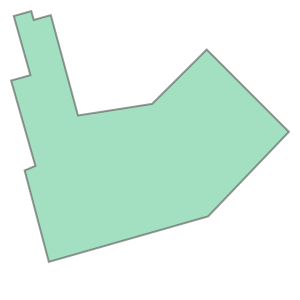

In [790]:
st

разбиение точек на группы по сегментам

In [791]:
def vec_from_point_chain(point_chain):
    ptch = np.asarray(point_chain).copy()
    return ptch - np.roll(ptch, -1, axis=0)



array([[ -90.9246656 ,  319.88111454],
       [  40.27832241,   17.18479321],
       [ -90.76909512,  342.68958635],
       [-597.223658  , -170.5044305 ],
       [-302.87805826, -317.0334789 ],
       [ 308.14240755, -308.39204586],
       [ 204.62842559,  203.5787197 ],
       [ 278.06133278,   43.47309615],
       [ 101.89771133, -376.15734404],
       [  63.93303586,   17.92899372],
       [   9.30055009,  -33.02320942],
       [  65.70811673,   18.42902405],
       [ -62.45231896,  221.67703935],
       [  72.29789361,   20.26814164]])

In [792]:
def unit(vec):
    return vec / np.linalg.norm(vec)


def modx(vecs):
    return np.where(vecs[:, 0] < 0.0, vecs.T, vecs.T * (-1)).T


def mody(vecs):
    return np.where(vecs[:, 1] < 0.0, vecs.T, vecs.T * (-1)).T


def angle(A, B):
    return np.arccos(np.dot(unit(A), unit(B)))


def theta(xaxis):
    return angle(np.array([1, 0]), xaxis)


def rot_matrix(theta):
    rot = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]

    ])
    return rot


def rot_matrix_affine(theta):
    rot = np.array([
        [np.cos(theta), -np.sin(theta), 0.0],
        [np.sin(theta), np.cos(theta), 0.0]

    ])
    return rot


def rotate2d(vec, theta):
    return rot_matrix(theta) @ np.asarray(vec)


def choise_axis_2d(vecs, k=(0, 3, 4, 7)):
    labels = []
    for vec in vecs[..., :2]:
        ang = angle(np.array([1, 0]), np.asarray(vec))
        aa, _ = divmod(ang, pi / 4)
        labels.append(0) if aa in k else labels.append(1)
    return labels


def basis_to_custom_canonical_form(vecs):
    x_like = [0, 3, 4, 7]  # y_like = [1, 2, 5, 6]

    l, th, thr, axis = [], [], [], []

    for vec in vecs[..., :2]:

        ang = angle(np.array([1, 0]), np.asarray(vec))
        aa, bb = divmod(ang, pi / 4)

        if aa in x_like:
            vec_x = vec * (-1) if vec[0] < 0.0 else vec
            l.append([vec_x, rotate2d(vec_x, theta=0.5 * pi)])
            th_ = theta(vec_x)
            th.append(th_)
            thr.append(rot_matrix_affine(th_))
            axis.append(0)
        else:
            vec_y = vec * (-1) if vec[1] < 0.0 else vec
            l.append([rotate2d(vec_y, theta=-0.5 * pi), vec_y])
            th_ = theta(rotate2d(vec_y, theta=-0.5 * pi))
            th.append(th_)
            thr.append(rot_matrix_affine(th_))
            axis.append(1)
    return np.asarray(l), np.asarray(th), np.asarray(thr), np.asarray(axis)

In [793]:
from math import pi
def cross_m(va, vb):
    v_o_norm, v_t_norm = va / np.linalg.norm(va), vb / np.linalg.norm(vb)
    return np.cross(v_o_norm, v_t_norm)

def perimetr_decomposition_metric(va, vb, k=0.125, const=pi/2):
    _cross=cross_m(va, vb)
    ang = angle(va, vb)
    return (_cross < -k) or (ang - (const * (round(ang / const))) > k)

def pdm_solve(Va, Vb, **kwargs):
    _labels=[]
    for va, vb in zip(Va, Vb):
        _labels.append(perimetr_decomposition_metric(va, vb, **kwargs))

    return np.asarray(_labels)


In [794]:
def pointorder(indices):
    return [*indices, indices[0] + indices[-1] + 1]

def get_parts(indices, order):
    return [(np.tile(indices,2)[order[c]:order[c + 1]+1]).tolist() for c in range(len(order) - 1)]
def get_vectors(indices, order):
    return [(np.tile(indices,2)[order[c]:order[c + 1]]).tolist() for c in range(len(order) - 1)]
def get_linestring (indices, order):
    return [LineString(np.tile(indices,2)[order[c]:order[c + 1]+1]).tolist() for c in range(len(order) - 1)]
def part_data_from_index(data, indices):
    part_data=[]
    for i in indices:
        part=[]
        for j in i:
            part.append(data[j])
        part_data.append(part)
    return part_data

In [795]:
def perimetr_decomposition(point_list, k=0.125, **kwargs):
    Va=vec_from_point_chain(point_list)
    Vb=np.roll(vvvv,-1, axis=0)
    return pdm_solve(Va,Vb, k=k, **kwargs)

pdm=perimetr_decomposition(coor_list)
indices = np.arange(len(pdm))
order=pointorder([i+1 for i in indices[pdm]])
ixs=get_parts(indices, order)
vixs=get_vectors(indices, order)
parts = part_data_from_index(coor_list,ixs)
vixs

[[1, 2, 3], [4, 5, 6], [7], [8, 9], [10, 11, 12], [13, 0]]

In [818]:

def batch_point_to_vector(points):
    for batch in points:
        yield vec_from_point_chain(batch)

vector_chains=list(batch_point_to_vector(parts))

In [819]:
vector_chains

[array([[  40.27832241,   17.18479321],
        [ -90.76909512,  342.68958635],
        [-597.223658  , -170.5044305 ],
        [ 647.71443071, -189.36994907]]),
 array([[-302.87805826, -317.0334789 ],
        [ 308.14240755, -308.39204586],
        [ 204.62842559,  203.5787197 ],
        [-209.89277487,  421.84680506]]),
 array([[ 278.06133278,   43.47309615],
        [-278.06133278,  -43.47309615]]),
 array([[ 101.89771133, -376.15734404],
        [  63.93303586,   17.92899372],
        [-165.83074719,  358.22835032]]),
 array([[   9.30055009,  -33.02320942],
        [  65.70811673,   18.42902405],
        [ -62.45231896,  221.67703935],
        [ -12.55634786, -207.08285398]]),
 array([[  72.29789361,   20.26814164],
        [ -90.9246656 ,  319.88111454],
        [  18.62677199, -340.14925618]])]

SVD

In [797]:
from scipy.linalg import svd
import numpy as np
import torch



In [798]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        #self.A = m
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        #U, S, Vh = svd(self.A, **kwargs)
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        #Sigma = np.diag(S)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([self.A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))

In [799]:
pck = SvdPack()

In [800]:
pck_all = SvdPack()



In [801]:

a,b,c,d = basis_to_custom_canonical_form(vvvv)
partsv=part_data_from_index(a[:,0,:],vixs)

partsv

[[array([40.27832241, 17.18479321]),
  array([342.68958635,  90.76909512]),
  array([597.223658 , 170.5044305])],
 [array([ 317.0334789 , -302.87805826]),
  array([308.39204586, 308.14240755]),
  array([204.62842559, 203.5787197 ])],
 [array([278.06133278,  43.47309615])],
 [array([376.15734404, 101.89771133]), array([63.93303586, 17.92899372])],
 [array([33.02320942,  9.30055009]),
  array([65.70811673, 18.42902405]),
  array([221.67703935,  62.45231896])],
 [array([72.29789361, 20.26814164]), array([319.88111454,  90.9246656 ])]]

In [802]:

b_ = np.asarray(np.concatenate(partsv))
pck_all.matrices = b_
b_

tensor([[-0.0401, -0.0102, -0.5576, -0.5531, -0.1441, -0.0962, -0.2831, -0.3548,
         -0.0599, -0.0309, -0.0616, -0.2075, -0.0677, -0.2989],
        [-0.3260,  0.0291, -0.2152,  0.6358, -0.5308, -0.3505, -0.0317, -0.1251,
         -0.0224, -0.0117, -0.0230, -0.0783, -0.0253, -0.1145],
        [-0.5714,  0.0249,  0.6924, -0.2717, -0.0982, -0.0654, -0.1531, -0.1952,
         -0.0330, -0.0170, -0.0339, -0.1144, -0.0373, -0.1649],
        [-0.1976,  0.8375, -0.1306,  0.1878,  0.3482,  0.2293, -0.1286, -0.0926,
         -0.0146, -0.0075, -0.0150, -0.0501, -0.0165, -0.0707],
        [-0.3542, -0.4483, -0.1771,  0.2334,  0.7254, -0.1815, -0.0526, -0.1070,
         -0.0187, -0.0097, -0.0192, -0.0650, -0.0211, -0.0945],
        [-0.2348, -0.2956, -0.1174,  0.1534, -0.1813,  0.8802, -0.0350, -0.0710,
         -0.0124, -0.0064, -0.0127, -0.0431, -0.0140, -0.0627],
        [-0.2564,  0.0868, -0.1402, -0.1875, -0.0092, -0.0063,  0.9244, -0.0899,
         -0.0151, -0.0078, -0.0155, -0.0523, -0.0

array([[  40.27832241,   17.18479321],
       [ 342.68958635,   90.76909512],
       [ 597.223658  ,  170.5044305 ],
       [ 317.0334789 , -302.87805826],
       [ 308.39204586,  308.14240755],
       [ 204.62842559,  203.5787197 ],
       [ 278.06133278,   43.47309615],
       [ 376.15734404,  101.89771133],
       [  63.93303586,   17.92899372],
       [  33.02320942,    9.30055009],
       [  65.70811673,   18.42902405],
       [ 221.67703935,   62.45231896],
       [  72.29789361,   20.26814164],
       [ 319.88111454,   90.9246656 ]])

In [803]:
mata=np.asarray(partsv, dtype=object)
pck.matrices = mata
mata

tensor([[-0.0606,  0.6910, -0.7203],
        [-0.4948, -0.6476, -0.5795],
        [-0.8669,  0.3213,  0.3811]], dtype=torch.float64) tensor([716.4313,   8.1783], dtype=torch.float64) tensor([[-0.9627, -0.2705],
        [-0.2705,  0.9627]], dtype=torch.float64) tensor([[716.4313,   0.0000],
        [  0.0000,   8.1783]], dtype=torch.float64)
set item id: 0:0:0
tensor([[-0.0671,  0.9977, -0.0012],
        [-0.8319, -0.0566, -0.5520],
        [-0.5509, -0.0360,  0.8338]], dtype=torch.float64) tensor([523.2039, 438.0382], dtype=torch.float64) tensor([[-0.7464, -0.6655],
        [ 0.6655, -0.7464]], dtype=torch.float64) tensor([[523.2039,   0.0000],
        [  0.0000, 438.0382]], dtype=torch.float64)
set item id: 0:0:1
tensor([[-1.]], dtype=torch.float64) tensor([281.4392], dtype=torch.float64) tensor([[-0.9880, -0.1545],
        [-0.1545,  0.9880]], dtype=torch.float64) tensor([[281.4392]], dtype=torch.float64)
set item id: 0:0:2
tensor([[-0.9858, -0.1680],
        [-0.1680,  0.9858]], dty

array([list([array([40.27832241, 17.18479321]), array([342.68958635,  90.76909512]), array([597.223658 , 170.5044305])]),
       list([array([ 317.0334789 , -302.87805826]), array([308.39204586, 308.14240755]), array([204.62842559, 203.5787197 ])]),
       list([array([278.06133278,  43.47309615])]),
       list([array([376.15734404, 101.89771133]), array([63.93303586, 17.92899372])]),
       list([array([33.02320942,  9.30055009]), array([65.70811673, 18.42902405]), array([221.67703935,  62.45231896])]),
       list([array([72.29789361, 20.26814164]), array([319.88111454,  90.9246656 ])])],
      dtype=object)

In [804]:
pck_ah = pck.Vh
pck_all.Vh, pck_ah

([tensor([[-0.9564, -0.2921],
          [ 0.2921, -0.9564]], dtype=torch.float64)],
 [tensor([[-0.9627, -0.2705],
          [-0.2705,  0.9627]], dtype=torch.float64),
  tensor([[-0.7464, -0.6655],
          [ 0.6655, -0.7464]], dtype=torch.float64),
  tensor([[-0.9880, -0.1545],
          [-0.1545,  0.9880]], dtype=torch.float64),
  tensor([[-0.9651, -0.2617],
          [-0.2617,  0.9651]], dtype=torch.float64),
  tensor([[-0.9626, -0.2711],
          [-0.2711,  0.9626]], dtype=torch.float64),
  tensor([[-0.9619, -0.2732],
          [-0.2732,  0.9619]], dtype=torch.float64)])

In [805]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]+ i[1][0] == 0:
            print (i)
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked

identical_matricies = matricies_check(pck_ah)

tensor([[-0.7464, -0.6655],
        [ 0.6655, -0.7464]], dtype=torch.float64)


In [806]:
def transform_chains_from_vh(coor_list, chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_ta = transform_chains_from_vh(coor_list, ixs, pck_ah)
pt_b =[(pck_all.Vh[0] @ np.asarray(i)).tolist() for i in coor_list]

In [807]:
pt_b

[[-198.54299384118383, -650.1139987404546],
 [-192.07190790968014, -317.6243788990073],
 [-148.53063197695704, -312.95344068442046],
 [-135.2488606311659, 41.30462312047695],
 [-756.230852245163, 52.67232225169358],
 [-1138.5007182373984, -162.07193139751223],
 [-933.8703564426389, -547.0184371791274],
 [-678.7037060604588, -412.0848675671983],
 [-400.06992486718156, -451.7236219958049],
 [-412.48361881586754, -841.240491017337],
 [-346.1017534655098, -842.7668730087632],
 [-346.8521836665056, -877.0665734006523],
 [-278.6265929505532, -878.6331950821381],
 [-273.60817636348213, -648.3815557554343]]

Вкорячивание повернутого баундинг ректангла

In [808]:
def bounding_rectangle (points):
    bound_rec = np.asarray(MultiPoint([i for i in points]).minimum_rotated_rectangle.exterior.coords)
    return bound_rec

v = bounding_rectangle(pt_b)
v.tolist()

[[-1129.4782423340453, 78.58006907988769],
 [-1164.1583181066107, -846.4242978782402],
 [-169.92893640373123, -883.6997438376509],
 [-135.24886063116588, 41.30462312047695],
 [-1129.4782423340453, 78.58006907988769]]

In [809]:
def chains_tovec (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

def chains_base (point_list, parts):
    vectors =[]
    for i in parts:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_tovec(p_ta)
v_ = chains_base(pt_b, ixs)
v_t

[[[-43.42497300039571, -5.650848924623688],
  [-5.296056490406386, -354.4673934320716],
  [621.0804736228524, 2.627503917685935]],
 [[437.051813436825, 35.08642604567632],
  [-24.780513831966346, 435.25087411279594],
  [-288.2151809707, -15.782811330866977]],
 [[-281.43918503775285, 0.0]],
 [[0.09749821437554829, 389.7146155122839],
  [-66.3969457509927, -0.5722624542247559]],
 [[-0.0003672859066341516, 34.30790859736305],
  [-68.24353577478854, 0.07319145241206115],
  [0.021633113108464386, -230.30632090692666]],
 [[-75.08472736484697, 0.2582679788633868],
  [0.0583125253329797, -332.5525805870291]]]

In [810]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle (v_tr, v_b):
    ang =[]
    for j, i in enumerate(v_tr):
        for ind, val in enumerate(i):
            ang.append(angle_between(val, v_b[j][ind]))
            break
    return ang

angl = angle(v_t, v_)
aa,bb=np.divmod(angl, pi/2)
huy = np.abs(bb-aa*pi/2)
angl

[0.02253447181991805,
 0.4317198234096262,
 0.1413129058003907,
 0.031608502834788665,
 0.021885838291758036,
 0.01963541160992082]

Хуй знает какой лучше, просто дерьмо какое-то

In [811]:
def  clusterize(angles, eps=0.2):
    points_sorted = sorted(angles)
    curr_point = points_sorted[0]
    curr_cluster = 0
    angles[angles.index(points_sorted[0])] = 0
    for point in points_sorted[1:]:
        if point <= curr_point + eps:
            angles[angles.index(point)] = curr_cluster
        else:
            curr_cluster+=1
            angles[angles.index(point)] = curr_cluster
        curr_point = point
    return angles


labels = clusterize(angl)
labels

[0, 1, 0, 0, 0, 0]

In [812]:
scope = np.asarray(angl)/np.linalg.norm(angl)
r = np.round(scope*len(angl),0)
labells=[]
l = np.unique(r).tolist()
for i in r:
    labells.append(l.index(i))
print(labells)

[0, 1, 0, 0, 0, 0]


Работа с транспортированными точками

In [812]:
from collections import defaultdict

d_ = defaultdict(list)
for la, l in zip(labels, ll):
    d_[la].append(l)

print(d_)

In [813]:

v=torch.tensor(c, requires_grad=True)
interp=torch.nn.functional.interpolate(v.T, scale_factor=3, mode='linear')

ag = torch.tensor(cc, requires_grad=True)

aff= torch.nn.functional.affine_grid(theta=ag, size=[14,2,4,4])

NameError: name 'cc' is not defined

In [ ]:
aff.shape
aff

In [ ]:
interp.T

In [ ]:
aann=aff*torch.norm(torch.tensor(coor_list))
affnp=aff.detach().numpy()
affnp.tolist()

mg=torch.stack(torch.meshgrid(torch.linspace(0,1,8),torch.linspace(0,1,8)))
mg.shape

In [ ]:
U, S, Vh=v.svd()

In [ ]:
S[0]

Работа с транспортированными точками

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
for d in d_[0]:
    ax.plot(*d.xy, label='LineString', color='#ff00b4')
for d in d_[1]:
    ax.plot(*d.xy, label='LineString', color='#ffa200')
for d in d_[2]:
    ax.plot(*d.xy, label='LineString', color='#ff0000')
for d in d_[3]:
    ax.plot(*d.xy, label='LineString', color='#00ff54')
for d in d_[4]:
    ax.plot(*d.xy, label='LineString', color='#0012ff')
for d in d_[5]:
    ax.plot(*d.xy, label='LineString', color='#ffcc00')
for d in d_[6]:
    ax.plot(*d.xy, label='LineString', color='#9c00ff')

plt.show()